<a href="https://colab.research.google.com/github/jaeseonim/my-ai-journey/blob/main/karpathy-ai-study/02_makemore_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

In [4]:
# /content/drive/MyDrive/karpathy/names.txt

words = open('/content/drive/MyDrive/karpathy/names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [5]:
len(words)

32033

In [6]:
min(len(w) for w in words)

2

In [7]:
max(len(w) for w in words)

15

bigram으로 시작. bigram은 오로지 다음 문자만 예측하지만 langauge model 시작하기에 좋다

pytorch의 'broadcasting semantics' 문서를 잘 읽어봐라.

[링크](https://docs.pytorch.org/docs/stable/notes/broadcasting.html)

keepdim = True vs. False

강의에서 sampling이라는 단어를 많이 쓴다!

모델이 이름을 하나 지어내는 과정은 다음과 같습니다:
- 시작(Seed): 항상 특수 문자인 마침표(.)에서 시작합니다.
- 확률 확인: 현재 문자(처음엔 .)에 해당하는 행(Row)을 확률 행렬 $P$에서 찾습니다.
- 선택(Sampling): 그 행에 적힌 확률들에 따라 torch.multinomial을 사용해 다음 글자를 '무작위'로 하나 뽑습니다.
- 반복: 새로 뽑힌 글자를 다음 입력으로 삼아 2~3단계를 계속 반복하다가, 다시 마침표(.)가 나오면 멈춥니다.


왜 '생성(Generating)' 대신 '샘플링'이라고 부를까요?

우리는 확률 분포라는 전체 집단(Population)에서 특정한 표본(Sample) 하나를 끄집어내는 것이기 때문에 샘플링이라는 표현을 씁니다.

예를 들어, 'A' 다음에 'B'가 올 확률이 70%, 'C'가 올 확률이 30%라고 모델이 학습했다면, 'B'와 'C'가 섞인 거대한 확률 주머니가 있는 셈입니다.

우리가 주사위를 던져서 실제로 'B'라는 글자 하나를 확정 짓는 행위가 바로 이 주머니에서 표본 하나를 추출(Sampling) 하는 것이죠.

만약 가장 높은 확률을 가진 글자만 무조건 뽑는다면(이건 Argmax라고 합니다), 모델은 매번 똑같은 이름만 생성하게 됩니다. 하지만 샘플링을 하면 확률이 낮은 글자도 가끔 뽑히기 때문에, 모델이 매번 조금씩 다른 이름을 생성하는 '창의성'을 보여줄 수 있게 됩니다.

안드레의 팁: 강의 후반부에 우리가 만든 바이그램 모델로 샘플링을 해봤을 때, 꽤 그럴듯한 이름(예: mor)도 나오지만 말도 안 되는 이름(예: h)도 나왔던 것 기억하시나요? 그게 바로 모델이 가진 통계적 지능의 한계이자 샘플링이 보여주는 날 것 그대로의 결과물입니다.

모델의 quality를 계산해보자.

모델을 다 만들고 나면, 이 녀석이 얼마나 똑똑한지(혹은 멍청한지)를 하나의 숫자로 요약해서 보고 싶어지죠. 그래서 우리는 '가능도(Likelihood)'라는 개념을 가져옵니다.



likelihood: 모든 확률값을 곱해 -> `a * b * c`

log likelihood: 각 확률값에 로그를 씌운 다음에 더해 -> log(`a * b * c`)

근데 이렇게 하면 1에 가까울수록 0이고, 0에 가까울수록 음수 무한대로 간다.

손실함수는 이 의미와 반대이므로 log likelihood에 음수를 붙여준다. 이를 'negative log likelihood'라고 한다.

여기서 개수(3)으로 나누어 정규화도 해준다.

likelihood에 대한 개념부터 짚고 넘어가자.

likelihood는 우리 모델이 실제 데이터셋을 얼마나 잘 설명하는가에 대한 개념이다. <=> Likelihood의 원래 의미는 **"내가 세운 모델(파라미터 $\theta$)이 지금 내 눈앞에 있는 실제 데이터($D$)를 얼마나 잘 설명하는가?"**에 대한 척도입니다.

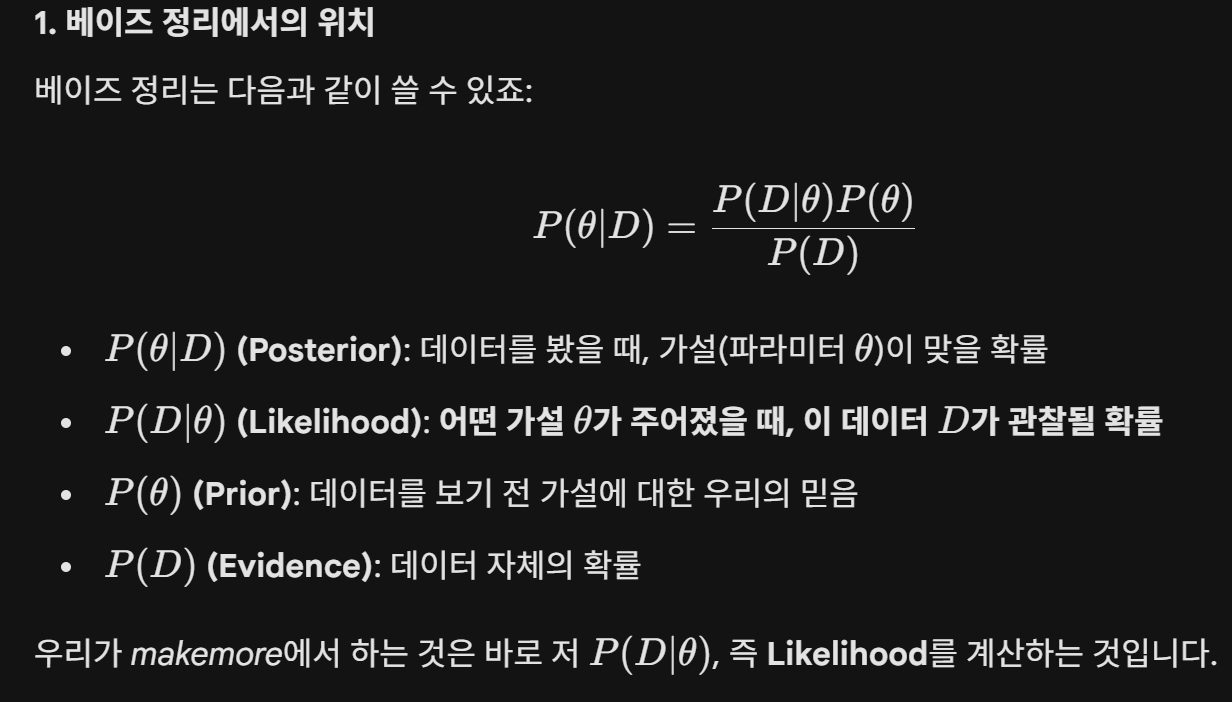

maximum likelihood estimation ([위키피디아](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation))

https://www.youtube.com/watch?v=vzNRLY_hLlM&list=PLRUS1nW-CfnfWT3ORO0ZmjgUQaCkRhEZM&index=16 -> 이 강의도 좋다

훈련의 목표는 손실함수(negative log likelihood)의 값을 최소화하는 매개변수 값을 찾는 것이다!

bigram 표를 통해서 확률분포를 구한건데 이개 곧 매개변수 값(모델)이라고 할 수 있지 않을까? -> 매개변수는 이미 정한거고, 여기서 데이터값이 나올 확률이 likelihood라고 일단 1차적으로 이해하자

지금까지는 단순히 count를 통해 구했다면, 이제는 다른 방법을 사용해보고자 한다.

In [12]:
# 1. 모든 단어를 합쳐서 고유한 알파벳 리스트를 만들고 정렬합니다.
chars = sorted(list(set(''.join(words))))

# 2. 글자 -> 숫자로 매핑하는 사전을 만듭니다. (a=1, b=2, ..., z=26)
stoi = {s:i+1 for i,s in enumerate(chars)}

# 3. 특수 문자 '.'를 0번에 할당합니다.
stoi['.'] = 0

# 4. 반대로 숫자 -> 글자로 바꿔주는 사전도 만들어두면 나중에 편리합니다.
itos = {i:s for s,i in stoi.items()}

In [14]:
import torch

In [15]:
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [16]:
xs

tensor([ 0,  5, 13, 13,  1])

In [17]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
# 정수를 그대로 input과 output으로 쓰는 건 적절치 않음
# 우리는 각 문자를 정수로 라벨링했는데, 1과 5에 대해서 5배 관계가 아니기 때문. 보통 키 같은 건 인정이지만 여기선 ㄴㄴ
# 그리고 뉴럴넷은 y = wx + b 형태로 계산하는데, x y 가 하나의 스칼라 값이라면 모든 x는 동일한 가중치 w를 공유하게 됨
# 하지만 원핫인코딩하면 각각의 X는 자신만의 독립적인 가중치를 갖게 된다
# 딥러닝에서는 x @ W를 한다. 그러면 x가 c = [0,0,1,0,...]라면 c를 담당하는 W의 가중치는 3번째 행에 있다.

수학적 관점 ($Wx$) vs 공학적 관점 ($xW$)

- 수학 교과서 ($Wx$): 보통 데이터 하나($x$)를 열 벡터(Column Vector)로 처리합니다. 그래서 가중치 행렬 $W$가 앞에 와야 행렬 곱셈의 차원이 맞습니다.
- 딥러닝 코드 ($xW$): 데이터를 배치(Batch) 단위로 처리하기 때문입니다. 딥러닝에서 데이터는 보통 행(Row) 방향으로 쌓입니다. 즉, $x$의 첫 번째 차원이 데이터의 개수(배치 크기)가 됩니다.

In [19]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() # 정수를 원핫 벡터로 변환
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [20]:
xenc.shape

torch.Size([5, 27])

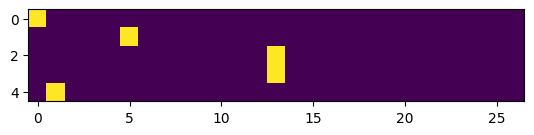

In [21]:
import matplotlib.pyplot as plt

plt.imshow(xenc)

In [24]:
# float로 바꿔주는 이유는 다양한 값을 가지게 하기 위해서!
xenc.dtype

torch.float32

In [27]:
W = torch.randn((27,1))
# 행렬 곱셈은 내적(dot product)의 병렬 연산이다. 한번에 계산해줌. 내적은 두 벡터가 얼마나 닮았냐를 나타냄.
# 이렇게 행렬 곱 통해 얻은 내적 값들의 뭉치를 logits라고 한다.
# 5개의 입력값을 동일한 뉴런(W)에 넣어버림 -> 각각의 X는 독립적인 값을 갖게 된다
# micrograd에서는 w * x + b 로 했지? 이때는 w와 x가 둘 다 벡터였어. 그래서 그냥 내적하면 되었지.
# 근데 여기서는 5개 한꺼번에 하니깐 행렬 곱셈을 하는 거야!
# 행렬 곱셈은 선형변환해서 차원을 바꿔주는 거라는 직관이 여기서 나오는구만
# 심지어 전강에서는 각각의 layer에 있는 노드들에 대해 각각 가중치 벡터를 만들었는데 이렇게 행렬로 해버리면 하나의 W 행렬로 표현 가능하려나?
xenc @ W

tensor([[-0.0444],
        [ 1.5854],
        [ 0.7351],
        [ 0.7351],
        [ 0.0973]])

In [28]:
# (27,1) 대신 (27,27)
W = torch.randn((27,27))
xenc @ W

tensor([[-0.1329,  0.8217,  0.2164, -0.9963,  0.0396,  0.3632, -0.2334,  0.1250,
         -1.5220, -0.0287,  0.1146,  0.4939, -0.7779,  1.8853,  0.1540,  0.8798,
          1.2367,  0.4043,  1.1369, -1.2885, -0.8000,  0.3206, -1.5257,  1.8808,
         -1.5034, -1.6851,  1.4643],
        [-1.1973, -0.4157, -0.1494,  0.3546, -0.6276,  0.9548, -0.4738,  0.7773,
         -0.1299, -0.4092,  0.0696,  0.1672, -0.1216,  0.8277, -0.5758,  0.6263,
          1.4091,  0.7412, -1.6012,  0.2703,  0.8326,  1.2989,  0.2061,  0.1503,
          0.4735,  0.4823, -1.7300],
        [ 1.5758,  0.1233,  0.4914, -1.0339, -1.0920,  0.7410,  0.4523, -0.6079,
         -1.7882,  0.9084, -0.7426, -0.0167, -1.0249, -0.0181,  0.4706, -0.7357,
         -0.7003,  0.5214, -0.6449,  0.7520, -0.7568,  1.2156,  1.1613,  0.1416,
         -0.5154,  0.3088,  1.0296],
        [ 1.5758,  0.1233,  0.4914, -1.0339, -1.0920,  0.7410,  0.4523, -0.6079,
         -1.7882,  0.9084, -0.7426, -0.0167, -1.0249, -0.0181,  0.4706, -0.7357

In [29]:
# 위의 각각의 값은 정규분포 따르는 음수 양수 값을 모두 가짐
# 우리는 이를 확률로서 해석하고 싶기 때문에 일단 양수로 만들어주기 위해서 exp()를 씌운다.
# 그러면 음수값은 1보다 작은 값이 되고, 양수값은 1보다 큰 값이 된다
# exp()를 씌우면 아까 bigram table에서 봤었던 count로 볼 수 있지. 둘 다 양수값.
(xenc @ W).exp()

tensor([[ 0.8756,  2.2743,  1.2415,  0.3693,  1.0404,  1.4380,  0.7918,  1.1331,
          0.2183,  0.9717,  1.1214,  1.6386,  0.4593,  6.5883,  1.1665,  2.4104,
          3.4441,  1.4983,  3.1170,  0.2757,  0.4493,  1.3779,  0.2175,  6.5587,
          0.2224,  0.1854,  4.3245],
        [ 0.3020,  0.6599,  0.8612,  1.4256,  0.5338,  2.5983,  0.6226,  2.1756,
          0.8782,  0.6642,  1.0721,  1.1820,  0.8855,  2.2880,  0.5622,  1.8706,
          4.0921,  2.0984,  0.2017,  1.3103,  2.2992,  3.6653,  1.2289,  1.1622,
          1.6057,  1.6198,  0.1773],
        [ 4.8345,  1.1312,  1.6346,  0.3556,  0.3355,  2.0980,  1.5719,  0.5445,
          0.1673,  2.4803,  0.4759,  0.9834,  0.3588,  0.9820,  1.6010,  0.4791,
          0.4964,  1.6845,  0.5247,  2.1213,  0.4692,  3.3723,  3.1941,  1.1521,
          0.5973,  1.3618,  2.7999],
        [ 4.8345,  1.1312,  1.6346,  0.3556,  0.3355,  2.0980,  1.5719,  0.5445,
          0.1673,  2.4803,  0.4759,  0.9834,  0.3588,  0.9820,  1.6010,  0.4791

In [30]:
logits = xenc @ W # log-counts
counts = logits.exp() # bigram의 table과 동일
probs = counts / counts.sum(1, keepdims = True) # 정규화하는데 이게 softmax 함수네?
# 확률분포를 얻은 거임
probs

tensor([[0.0193, 0.0501, 0.0273, 0.0081, 0.0229, 0.0317, 0.0174, 0.0250, 0.0048,
         0.0214, 0.0247, 0.0361, 0.0101, 0.1451, 0.0257, 0.0531, 0.0758, 0.0330,
         0.0686, 0.0061, 0.0099, 0.0303, 0.0048, 0.1444, 0.0049, 0.0041, 0.0952],
        [0.0079, 0.0173, 0.0226, 0.0375, 0.0140, 0.0683, 0.0164, 0.0572, 0.0231,
         0.0175, 0.0282, 0.0311, 0.0233, 0.0601, 0.0148, 0.0492, 0.1076, 0.0552,
         0.0053, 0.0344, 0.0604, 0.0963, 0.0323, 0.0305, 0.0422, 0.0426, 0.0047],
        [0.1279, 0.0299, 0.0432, 0.0094, 0.0089, 0.0555, 0.0416, 0.0144, 0.0044,
         0.0656, 0.0126, 0.0260, 0.0095, 0.0260, 0.0423, 0.0127, 0.0131, 0.0446,
         0.0139, 0.0561, 0.0124, 0.0892, 0.0845, 0.0305, 0.0158, 0.0360, 0.0741],
        [0.1279, 0.0299, 0.0432, 0.0094, 0.0089, 0.0555, 0.0416, 0.0144, 0.0044,
         0.0656, 0.0126, 0.0260, 0.0095, 0.0260, 0.0423, 0.0127, 0.0131, 0.0446,
         0.0139, 0.0561, 0.0124, 0.0892, 0.0845, 0.0305, 0.0158, 0.0360, 0.0741],
        [0.0346, 0.2011,

In [31]:
# summary

In [57]:
xs

tensor([ 0,  5, 13, 13,  1])

In [58]:
ys

tensor([ 5, 13, 13,  1,  0])

In [59]:
g = torch.Generator().manual_seed(2147483647)
# gradient 구하기 위해 requires_grad = True 설정
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [76]:
# forward pass
# 아직 MLP가 아니라 SINGLE LINEAR LAYER 다.
xenc = F.one_hot(xs, num_classes = 27).float() # inputs to the network: one-hot encoding
logits = xenc @ W
# 아래 두 줄을 softmax라고 함
counts = logits.exp()
probs = counts / counts.sum(1, keepdim = True)
# 손실함수: 아까 살펴봤던 'average' negative log likelihood
# 손실함수가 0에 가깝다? -> likelihood를 곱한 값들이 1에 수렴한다...애초에 정답지가 확률값인 1이라고 이해하면 되네? 오...
loss = -probs[torch.arange(5), ys].log().mean()

In [77]:
# loop 돌릴수록 점점 줄어든다
print(loss)

tensor(3.6892, grad_fn=<NegBackward0>)


In [78]:
# backward pass
W.grad = None # gradient를 0으로 설정
# micrograd 때 했던 것처럼 pytorch에 backward() 메소드가 내장되어 있어
loss.backward()

In [79]:
# update
W.data += -0.1 * W.grad

In [80]:
# 다시 짜보자 이제

In [99]:
# create the dataset (모든 단어 이번엔!)
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of elements: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator = g, requires_grad=True)

number of elements:  228146


In [101]:
# gradient descent
for k in range(100):

  # forward pass

  xenc = F.one_hot(xs, num_classes = 27).float() # inputs to the network: one-hot encoding
  logits = xenc @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdim = True)
  # 5 대신 num
  loss = -probs[torch.arange(num), ys].log().mean()
  print(loss.item())

  # backward pass
  W.grad = None
  loss.backward()

  # update
  W.data += -50 * W.grad

2.4726526737213135
2.4724340438842773
2.4722204208374023
2.472010850906372
2.471806049346924
2.4716053009033203
2.471409320831299
2.4712166786193848
2.4710280895233154
2.4708433151245117
2.4706623554229736
2.4704854488372803
2.4703118801116943
2.4701414108276367
2.4699742794036865
2.4698104858398438
2.46964955329895
2.469492197036743
2.4693377017974854
2.4691860675811768
2.469036817550659
2.468891143798828
2.468747615814209
2.46860671043396
2.468468427658081
2.468332529067993
2.4681990146636963
2.4680681228637695
2.4679393768310547
2.4678127765655518
2.467688798904419
2.4675662517547607
2.4674463272094727
2.4673283100128174
2.467212438583374
2.467097759246826
2.4669857025146484
2.4668753147125244
2.466766834259033
2.4666595458984375
2.4665544033050537
2.466451406478882
2.4663491249084473
2.4662492275238037
2.4661502838134766
2.4660532474517822
2.4659576416015625
2.4658634662628174
2.4657704830169678
2.465679407119751
2.4655895233154297
2.465500593185425
2.4654135704040527
2.46532726287

In [102]:
# bigram 했을 때도 2.47의 loss 값이 나왔는데 위 훈련결과 비슷한 값이 나오는 걸 볼 수 있어

# Part 2